In [1]:
using CSV
using DataFrames
using Dates
using Distributions
using Gadfly

In [2]:
ENV["COLUMNS"] = 1000;

In [3]:
function plot_dist(dist; nsamples=100, range=(-1,1), xlabel="", title="", nticks=10)
    xstep = (range[2]-range[1])/(nsamples-1)
    xticksstep = round((range[2]-range[1])/(nticks-1), RoundUp, digits=1)
    
    xs = range[1]:xstep:range[2]
    ys = pdf.(dist, xs)
    
    xticks = range[1]:xticksstep:range[2]
    
    plot(
        x=xs,
        y=ys,
        ymax=ys,
        ymin=zeros(nsamples),
        Geom.line,
        Geom.ribbon,
        Guide.xlabel(xlabel),
        Guide.ylabel("Density"),
        Guide.title(title),
        Guide.xticks(ticks=xticks),
    ) |> SVG(16cm, 10cm)
end;

In [4]:
function compute_active(initial, admitted, los_dist)
    T = length(admitted)
    discharged = initial .* (pdf.(los_dist, 0:T-1))
    L = 1.0 .- cdf.(los_dist, 0:T)
    active = [
        (
            initial
            - sum(discharged[1:t])
            + sum(L[t-t₁+1] * admitted[t₁] for t₁ in 1:t)
        ) for t in 1:T
    ]
    return active
end;

In [5]:
capacity_data = DataFrame(CSV.File("../data/capacity_maryland.csv"))
capacity_data.capacity_total = capacity_data.capacity_icu + capacity_data.capacity_acute;

In [6]:
hospitals = sort(capacity_data.hospital);

In [7]:
start_date = Date(2020, 11, 25);
end_date   = Date(2021, 04, 01);
peak_date  = Date(2021, 01, 15);

In [8]:
date_range = collect(start_date : Day(1) : end_date);
T = length(date_range);

In [9]:
peak_date_t = findfirst(date_range .== peak_date);

In [10]:
los_dist = (
    icu = Weibull(1.58, 13.32),
    acute = Weibull(1.38, 12.88),
    allbeds = Weibull(1.38, 12.88),
);

In [11]:
start_load_dist = Normal(0.8, 0.1)

Normal{Float64}(μ=0.8, σ=0.1)

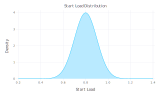

In [12]:
plot_dist(start_load_dist, range=(0.2,1.4), xlabel="Start Load", title="Start Load Distribution")

In [13]:
delta_load_dist = Normal(0.0, 0.1)

Normal{Float64}(μ=0.0, σ=0.1)

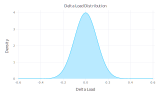

In [14]:
plot_dist(delta_load_dist, range=(-0.6,0.6), xlabel="Delta Load", title="Delta Load Distribution")

In [15]:
peak_delta_dist = Normal(0.4, 0.15)

Normal{Float64}(μ=0.4, σ=0.15)

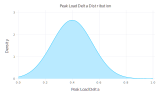

In [16]:
plot_dist(peak_delta_dist, range=(0,1), xlabel="Peak Load Delta", title="Peak Load Delta Distribution")

In [17]:
peak_date_dist = Truncated(Normal(0, 12), -15, 15)

Truncated(Normal{Float64}(μ=0.0, σ=12.0), range=(-15.0, 15.0))

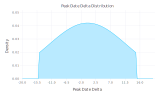

In [18]:
plot_dist(peak_date_dist, range=(-20,20), xlabel="Peak Date Delta", title="Peak Date Delta Distribution")

In [19]:
function generate_forecasts(bedtype)
    hospital_forecasts_list = DataFrame[]
    for (i,h) in enumerate(hospitals)
        start_load = rand(start_load_dist)

        Δload_total = rand(delta_load_dist)
        Δload = Δload_total / T
        end_load = start_load + Δload_total

        Δpeakload = rand(peak_delta_dist)

        Δpeakdate = round(Int, rand(peak_date_dist))
        peak_date_t_ = peak_date_t + Δpeakdate

        μ = peak_date_t
        σ = 15
        f(x) = (1/(σ*sqrt(2*π))) * exp(-0.5 * ((x-μ)/σ)^2)
        load_offset = [f(t) for t in 0:T-1]
        load_offset = load_offset .* (Δpeakload / maximum(load_offset))

        # @show (h, start_load, Δload_total, Δpeakload, peak_date_t)

        load_base = [start_load + (Δload*i) for i in 0:T-1]
        load = load_base + load_offset

        capacity = filter(row -> row.hospital == h, capacity_data)["capacity_$(bedtype)"][1]

        active = load .* capacity
        
        initial = active[1]
        discharged = initial .* (pdf.(los_dist[bedtype], 0:T-1))
        
        L = 1.0 .- cdf.(los_dist[bedtype], 0:T)
        
        A = [(t′ ≤ t) ? L[t-t′+1] : 0 for t in 1:T, t′ in 1:T]
        b = [active[t] - (initial - sum(discharged[1:t])) for t in 1:T]
        admitted = A \ b

        forecast = DataFrame(
            "hospital" => fill(h,T),
            "date" => date_range,
            "active_$(bedtype)" => active,
            "admitted_$(bedtype)" => admitted,
        )

        push!(hospital_forecasts_list, forecast)
    end
    
    hospital_forecasts = vcat(hospital_forecasts_list...)
    return hospital_forecasts
end;

In [20]:
hospital_forecasts_icu = generate_forecasts(:icu);
hospital_forecasts_acute = generate_forecasts(:acute);

In [21]:
hospital_forecasts_allbeds = DataFrame(
    hospital = hospital_forecasts_icu.hospital,
    date = hospital_forecasts_icu.date,
    active_allbeds = hospital_forecasts_icu.active_icu + hospital_forecasts_acute.active_acute,
    admitted_allbeds = hospital_forecasts_icu.admitted_icu + hospital_forecasts_acute.admitted_acute,
);

In [22]:
hospital_forecasts = outerjoin(hospital_forecasts_icu, hospital_forecasts_acute, hospital_forecasts_allbeds, on=[:hospital, :date]);

In [23]:
data_date = "2020_12_10";

In [24]:
hospital_forecasts |> CSV.write("../data/forecast_fake_$(data_date).csv");

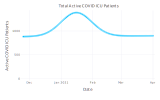

In [25]:
hospital_forecast_icu_total = combine(groupby(hospital_forecasts, :date), :active_icu => sum => :active_icu)
plot(
    hospital_forecast_icu_total,
    x=:date,
    y=:active_icu,
    Geom.point, Geom.line,
    Coord.cartesian(ymin=0),
    Guide.xlabel("Date"), Guide.ylabel("Active COVID ICU Patients"),
    Guide.title("Total Active COVID ICU Patients"),
) |> SVG(16cm, 10cm)

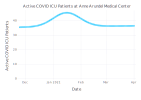

In [26]:
h_idx = 1
h = hospitals[h_idx]
hospital_forecast_ = filter(row -> row.hospital == h, hospital_forecasts)
plot(
    hospital_forecast_,
    x=:date,
    y=:active_icu,
    Geom.point, Geom.line,
    Coord.cartesian(ymin=0),
    Guide.xlabel("Date"), Guide.ylabel("Active COVID ICU Patients"),
    Guide.title("Active COVID ICU Patients at $(h)"),
) |> SVG()

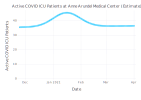

In [27]:
h_idx = 1
h = hospitals[h_idx]
hospital_forecast_ = filter(row -> row.hospital == h, hospital_forecasts)
sort!(hospital_forecast_, :date)
dates_ = Vector(hospital_forecast_.date)
admitted_icu_ = Vector(hospital_forecast_.admitted_icu)
active_icu_ = compute_active(hospital_forecast_.active_icu[1], admitted_icu_, los_dist[:icu])
plot(
    x=dates_,
    y=active_icu_,
    Geom.point, Geom.line,
    Coord.cartesian(ymin=0),
    Guide.xlabel("Date"), Guide.ylabel("Active COVID ICU Patients"),
    Guide.title("Active COVID ICU Patients at $(h) (Estimate)"),
) |> SVG()